In [36]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
!curl https://raw.githubusercontent.com/HariharasudhanAS/ML-Lab/master/Lab_2/id3.py > id3.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5120  100  5120    0     0  12427      0 --:--:-- --:--:-- --:--:-- 12397


## Theory

What decision trees try to do:
![Partition of an input space](https://raw.githubusercontent.com/HariharasudhanAS/ML-Lab/master/Lab_2/Partitioning-of-an-input-space-by-a-decision-tree.png)

<i><center>Source - Potts, Duncan & Sammut, Claude. (2019). Online Nonlinear System Identification in High Dimensional Environments.</center></i>

You can see the input space in the left and the tree formed in the right. This is a very simple problem we have considered to make it easier to visualize. We are basically trying to model the underlying distribution using the tree. The underlying distribution in real-life is mostly non-linear and thus cannot be modelled using a linear regression model. Trees help in this case as they are able to model non-linear functions better than linear-regression.

But since we cannot model the function perfectly (will need all datapoints corresponding to every single coordinate in the input space to perfectly model it), we try approximating it. To what level? This is the problem of [Bias-Variance tradeoff](https://hariharasudhanas.github.io/2018/10/15/bias-variance-tradeoff/)

Prediction using a linear regression model:

![Bias-Variance Tradeoff](https://i.imgur.com/BanS6li.png)

<i><center> Source - ISLR (Gareth James et al.) </center></i>

As you can see, the mean error of the model is dependent on the bais and variance of the model. The last term on the right is the error in samples (sample's that disobey the distribution) and are called irreducible error.

<img src="https://raw.githubusercontent.com/HariharasudhanAS/ML-Lab/master/Lab_2/tradeoff.png" alt="Tradeoff" style="width: 500px;"/>

<i><center> Source - <a href="https://community.alteryx.com/t5/Data-Science-Blog/Bias-Versus-Variance/ba-p/351862">Blog by Sydney Firmin</a> </center></i> 

We aim to acheive the sweet spot in the middle

The graphical representation of the models might resemble this

![overfitting](https://raw.githubusercontent.com/HariharasudhanAS/ML-Lab/master/Lab_2/overfitting2.png)

<i><center> Source - Andrew Ng's course on Coursera </center></i>

If you are interested in learning more, check this out - [Awesome lecture at University of British Columbia](https://youtu.be/-dCtJjlEEgM)


# ID3 Algorithm for Classification

We'll write code for Decision Trees which uses ID3 algorithm to build trees.

- Entropy:
\begin{align}
S_{0} = -\sum_i^Np_{i}log_{2}p_{i}
\end{align}
    - `find_entropy()` calulates entropy i.e. `S_0`
- Information Gain:
\begin{align}
I = S_{0} - \sum_i^q(N_{i}/N)*S_{i}
\end{align}
    - `find_max_ig()` calulates information gain i.e. `I`
    - `find_entropy_attribute()` calulates:
\begin{align} 
\sum_i^q(N_{i}/N)*S_{i}
\end{align}

**You are provided with a Decision Tree Class and you're required the complete the above mentioned class methods.**

In [37]:
import numpy as np
import pandas as pd
from pprint import pprint

In [38]:
data = pd.DataFrame(
    {'Taste':['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
     'Temperature':['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
     'Texture':['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
     'Eat':['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']},
    columns=['Taste','Temperature','Texture','Eat'])

In [39]:
data

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Spicy,Hot,Soft,No
2,Spicy,Hot,Hard,Yes
3,Spicy,Cold,Hard,No
4,Spicy,Hot,Hard,Yes
5,Sweet,Cold,Soft,Yes
6,Salty,Cold,Soft,No
7,Sweet,Hot,Soft,Yes
8,Spicy,Cold,Soft,Yes
9,Salty,Hot,Hard,Yes


In [40]:
class DecisionTree(object):

    def __init__(self):
        self.tree = None
        self.trained = False

    def fit(self, data_frame):
        if not isinstance(data_frame, pd.core.frame.DataFrame):
            raise ValueError('Please provide data_frame as an instance of pandas '+
                'DataFrame. Recieved data_frame as an instance of {}'.format(type(data_frame)))
        self.tree = self.buildTree(data_frame)
        self.trained = True
        print('Decision Tree trained successfully.')

    def buildTree(self, df, tree=None):
        """
        Here we build our decision tree
        """
        # Target variable
        Class = df.keys()[-1]
        # Get attribute with maximum information gain
        node = self.find_max_ig(df)
        # Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
        attValue = np.unique(df[node])
        # Create an empty dictionary to create tree
        if tree is None:                 
            tree={}
            tree[node] = {}
        # We make loop to construct a tree by calling this function recursively.
        # In this we check if the subset is pure and stops if it is pure.
        for value in attValue:
            subtable = self.get_subtable(df, node, value)
            clValue, counts = np.unique(subtable['Eat'], return_counts=True)
            # Checking purity of subset
            if len(counts)==1:
                # Subset is pure
                tree[node][value] = clValue[0]
            else:
                # Calling the function recursively
                tree[node][value] = self.buildTree(subtable)
        return tree

    def predict(self, X_test):
        if not self.trained:
            raise ValueError('You have to train the model before predicting. Use `model.fit(data)` to train')
        if not isinstance(X_test, pd.core.frame.DataFrame) \
            and not isinstance(X_test, pd.core.series.Series):
            raise ValueError('Please provide X_test as an instance of pandas '+
                'Series or DataFrame. Recieved X_test as an instance of {}'.format(type(X_test)))
        # If 1 sample is given
        if isinstance(X_test, pd.core.series.Series):
            return self.predict_sample(X_test, self.tree)
        # If multiple samples are given
        predictions = []
        for i in range(len(X_test)):
            predictions.append(self.predict_sample(X_test.iloc[i], self.tree))
        return predictions

    def predict_sample(self, sample, tree):
        """
        This function is used to predict for any input sample(s) 
        Recursively we go through the tree that we built during training
        """
        for nodes in tree.keys():  
            value = sample[nodes]
            tree = tree[nodes][value]
            prediction = 0    
            if type(tree) is dict:
                prediction = self.predict_sample(sample, tree)
            else:
                prediction = tree
                break
        return prediction

    def find_max_ig(self, df):
        """
        Given a dataframe, find maximum information gain among all attributes
        """
        ig_attributes = []
        attributes = df.keys()[:-1]
        for attribute in attributes:
            gain = # Fill here
            ig_attributes.append(gain)
        return attributes[np.argmax(ig_attributes)]

    def find_entropy(self, df):
        """
        Find total entropy from an attribute
        """
        Class = df.keys()[-1]
        entropy = 0
        labels = df[Class].unique()
        for label in labels:
            fraction = # Fill here
            entropy += # Fill here
        return entropy

    def find_entropy_attribute(self, df, attribute):
        """
        Find entropy from different values of an attribute
        """
        eps = np.finfo(float).eps
        # Class is target variable
        Class = df.keys()[-1]
        # labels are values in target variable (like 'YES'/'NO' or 0/1 etc.)
        labels = df[Class].unique()
        # variables are different values in that attribute (like 'Hot','Cold' in Temperature attribute)
        variables = df[attribute].unique()
        entropy2 = 0
        for variable in variables:
            entropy = 0
            for label in labels:
                numer = # Fill here
                denom = # Fill here
                fraction = numer/(denom+eps) # Why?
                entropy += # Fill here
            fraction2 = denom/len(df)
            entropy2 += # Fill here
        return abs(entropy2)

    def get_subtable(self, df, node, value):
        """
        Getting subset of dataset
        """
        return df[df[node] == value].reset_index(drop=True)

    def print_tree(self):
        """
        Print the decision tree
        """
        print('\n\t\t\t\t===Decision Tree===\n')
        pprint(self.tree)

In [42]:
# Uncomment to see solution
#!cat id3.py

In [43]:
model = DecisionTree()

In [44]:
model.fit(data)

Decision Tree trained successfully.


In [45]:
model.print_tree()


				===Decision Tree===

{'Taste': {'Salty': {'Texture': {'Hard': 'Yes', 'Soft': 'No'}},
           'Spicy': {'Temperature': {'Cold': {'Texture': {'Hard': 'No',
                                                          'Soft': 'Yes'}},
                                     'Hot': {'Texture': {'Hard': 'Yes',
                                                         'Soft': 'No'}}}},
           'Sweet': 'Yes'}}


In [46]:
model.predict(data.loc[0])

'No'

In [47]:
model.predict(data)

['No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes']

## Dataset

In [3]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/HariharasudhanAS/ML-Lab/master/Lab_2/train_data.csv")

In [4]:
df_raw.head()

,cement,blast,flyash,water,sp,ca,fa,age,strength
0,382.0,0.0,0.0,186.0,0.0,1047.0,739.0,7,24.00
1,310.0,142.8,0.0,167.9,10.0,914.3,804.0,28,45.30
2,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,90,35.76
3,475.0,118.8,0.0,181.1,8.9,852.1,781.5,91,74.19
4,385.0,0.0,0.0,186.0,0.0,966.0,763.0,3,14.70


In [5]:
df_raw.shape

(721, 9)

## Training, validation and testing

Underfitting occurs if the model or algorithm shows low variance but high bias (to contrast the opposite, overfitting from high variance and low bias). How do we make sure we don't under-fit or over-fit a model?

We use a seperate dataset called the validation dataset. Typical split of Train, validation and test dataset is 60:20:20.

Step 1: Fit our model on the train dataset using a set of hyperparameters


Step 2: Measure the score of our model on validation set


Step 3: If score on validation set is better than training set - we under-fit our training dataset. If score on validation set is worse than training set - we are overfitting
        
        
Step 4: Tune our hyperparameters such that the score is almost the same on both train and validation dataset.


<b>Note:</b> Never look into the test dataset. It might make you biased towards a particular idea. We assume that the test dataset follows the distribution of the train dataset. This might not be true especially in timeseries data, but there are other ways of dealing with it. 

In [45]:
# Scoring function, we use rmse

def score(y_actual, y_preds):
    return sqrt(mean_squared_error(y_actual, y_preds))

In [46]:
# Extract the target variable from train dataset

y = df_raw['strength']
df_raw.drop('strength', axis=1, inplace=True)

In [47]:
# Split train data into train and validation data

X_train, X_valid, y_train, y_valid = train_test_split(df_raw, y, test_size=0.3, shuffle=True)

## Fitting the model

In [281]:
## See source of function

??DecisionTreeRegressor

In [271]:
model1 = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)

In [272]:
%time model1.fit(X_train, y_train)

CPU times: user 4.75 ms, sys: 0 ns, total: 4.75 ms
Wall time: 4.6 ms


DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [273]:
score(y_train, model1.predict(X_train))

6.034861627895281

In [274]:
score(y_valid, model1.predict(X_valid))

9.450166404626753

In [275]:
# Overfitting to the train dataset

model2 = DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, random_state=42)

In [276]:
%time model2.fit(X_train, y_train)

CPU times: user 4.87 ms, sys: 0 ns, total: 4.87 ms
Wall time: 3.97 ms


DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [277]:
score(y_train, model2.predict(X_train))

2.7981994133888795

In [278]:
score(y_valid, model2.predict(X_valid))

9.371184783771666

[Text(167.4, 181.2, 'X[7] <= 21.0\nmse = 284.767\nsamples = 504\nvalue = 35.736'),
 Text(83.7, 108.72, 'X[0] <= 356.3\nmse = 133.316\nsamples = 153\nvalue = 23.041'),
 Text(41.85, 36.23999999999998, 'mse = 69.171\nsamples = 109\nvalue = 18.641'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 125.415\nsamples = 44\nvalue = 33.942'),
 Text(251.10000000000002, 108.72, 'X[0] <= 352.5\nmse = 249.921\nsamples = 351\nvalue = 41.269'),
 Text(209.25, 36.23999999999998, 'mse = 158.657\nsamples = 267\nvalue = 36.057'),
 Text(292.95, 36.23999999999998, 'mse = 179.228\nsamples = 84\nvalue = 57.835')]

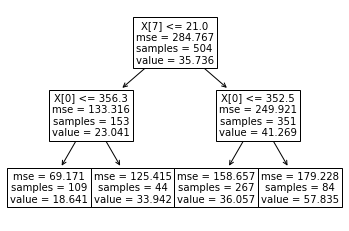

In [280]:
## Plotting a tree

model1 = DecisionTreeRegressor(max_depth=2, min_samples_leaf=10, random_state=42)

tree.plot_tree(model1.fit(X_train, y_train))

The above diagram implies that the tree has split the input space into 4

## Bagging

Trees have low bias inherently. Inorder to better model the dataset, we use RandomForests. This is a type of ensemble model - meaning it uses the result of many models to improve the final prediction.

This is done by bootstrapping and features sampling. 

<b>Bootstrapping:</b>

Bootstrapping in this context referes to the process of training many models on different subsets of the data (with resampling -ie replacement). The individual models are assumed to be of high variance which is the case in trees.

<b>Random feature subsampling:</b>

Each model does not have access to all columns of the dataset (All variables of the input space). A fraction of it is made available and the selection process is random for each model. 

The above methods maintain the same bias but reduce the variance

In [282]:
from sklearn.ensemble import RandomForestRegressor

In [283]:
model3 = RandomForestRegressor(max_features=0.7, bootstrap=True, max_depth=10, min_samples_leaf=2, random_state=42)

In [286]:
model3.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=0.7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [288]:
score(y_train, model3.predict(X_train))

3.50480923647186

In [287]:
score(y_valid, model3.predict(X_valid))

6.389048914645898

As you can see, it has worse score on train dataset and better score on validation dataset compared to Decision tree regresser using the same parameters

### Visualizing bagging

In [298]:
# Collect the prediction from different trees in the forest

preds = np.stack([t.predict(X_valid) for t in model3.estimators_])

In [299]:
# We have prediction for each of the 217 rows from all 10 trees in the forest

preds.shape

(10, 217)

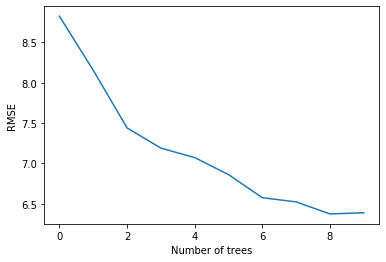

In [302]:
# Plot metric vs number of trees

from matplotlib import pyplot as plt
plt.plot([sqrt(mean_squared_error(y_valid, np.mean(preds[:i+1], axis=0))) for i in range(10)])
plt.xlabel('Number of trees')
plt.ylabel('RMSE');

## Kaggle contest

In [6]:
# All you had to do for last week's kaggle contest

df_raw = pd.read_csv("https://raw.githubusercontent.com/HariharasudhanAS/ML-Lab/master/Lab_2/train_data.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/HariharasudhanAS/ML-Lab/master/Lab_2/test_data.csv")

In [7]:
y = df_raw['strength']
df_raw.drop('strength', axis=1, inplace=True)

In [311]:
# Tweak hyperparameters

model = RandomForestRegressor()

In [312]:
model.fit(df_raw, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [315]:
test_preds = model.predict(df_test)
submit = pd.DataFrame()
submit['Id'] = np.arange(0,len(test_preds))
submit['Predicted'] = test_preds
submit.to_csv("sample_submission.csv", index=False)